# Modeling Script

> Models Available For This Project

In [ ]:
#| default_exp scripts.modeling

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#| export

from fastcore.script import Param, call_parse

from LTBP.data.utils import snowflake_query, get_yaml_dicts
from LTBP.modeling.utils import (
    create_stage_and_query_stage_sf, create_sklearn_preprocess_baseline_dict,
    return_list_of_vars, prepare_training_set, save_sklearn_object_to_data_lake
)
from LTBP.modeling.custom_utils import evaluate, send_holdout_results_to_sf

from machine_learning_utilities import preprocessing

from machine_learning_utilities.project_log import project_log

from sklearn.pipeline import Pipeline

import LTBP.modeling.models as ds_models
import os
import logging
import json

/Users/jeremydemlow/miniforge3/envs/ltbp/lib/python3.9/site-packages/snowflake/connector/options.py:96: UserWarning: You have an incompatible version of 'pyarrow' installed (6.0.0), please install a version that adheres to: 'pyarrow<8.1.0,>=8.0.0; extra == "pandas"'
  warn_incompatible_dep(


In [ ]:
#| hide
from pathlib import Path
import yaml

In [ ]:
#| skip
def write_yaml_file(file_path: str, file_name: str, dictionary: dict):
    with open(Path(file_path, file_name), 'w') as f:
        yaml.dump(dictionary, f)

models_dict = dict({
    'preprocessors_adls_path' : 'preprocessors/',
    'modeling_adls_path' : 'modeling/',
    'predictions_adls_path': 'predictions/',
    'connection_str': 'DATALAKE_CONN_STR_SECRET',
    'sas_token' : 'DATALAKE_SAS_TOKEN_SECRET',
    'hold_out_table' : 'LTBP_HOLDOUT_TEST_MODEL_RESULTS',
    'tracking_table' : 'LTBP_MODEL_TRACKING_FY23',
    'identification': ['ECID', 'SEASONYEAR'],
    'inference_sf_table_name': 'LTBP_PREDICTIONS_FY23',
    'BASELINE': {
        'description': 'Standard baseline xgb_hyperopt approach status quo of LTBP of the past',
        'model_trainer': 'train_xgb',
        'y_preprocess_object_name': None,
        'y_scaler_type' : None,
        'x_preprocess_object_name': 'standard_pipe.pickle',
        'hyperopt_evals' : 2,
        'hyper_opt_subsample_size': 2750000,
        'training_subsample_size' : 5000000,

    },
    'NOHYPEROPT': {
        'description': 'Only here to see if it works delete at some point xgb_fit_only',
        'model_trainer': 'train_xgb_basic',
        'y_preprocess_object_name': None,
        'y_scaler_type' : None,
        'x_preprocess_object_name': 'standard_pipe.pickle',
        'hyper_opt_subsample_size' : None,
        'hyer_opt_subsample_size': None,
        'training_subsample_size' : 5000000,
    }
})

write_yaml_file('./LTBP/files/yaml_files/', 'models.yaml', models_dict)

# Script

This is the DSDE standard process for using Xboost with hyperopt

In [ ]:
#| export




@call_parse
def model_train(
    yaml_file_list: Param(help="YAML files to read", type=list, default=['features.yaml', 'udf_inputs.yaml', 'etl.yaml', 'models.yaml']),  # noqa:
    experiment_name: Param(help="YAML section to read", type=str, default='BASELINE'),  # noqa:
    experiment: Param(help="YAML section to read", type=bool, default=True),  # noqa:
    test_set: Param(help="Create a Test Set From Training Data", type=bool, default=True),  # noqa:
    sfSchema: Param(help="dev queries dev schema anything else will query project schema", type=str, default='dev')  # noqa:
    ):  # noqa:

    # Grab all yaml files for current probject
    features, udf_inputs, etl_dict, models_dict = get_yaml_dicts(yaml_file_list)

    # Create Snowflake Stage and Query Experiment location or commit location and return training data
    sf = snowflake_query(sfSchema='dev' if sfSchema.lower() == 'dev' else sfSchema)
    df = create_stage_and_query_stage_sf(
        sf=sf,
        etl=etl_dict,
        udf_inputs=udf_inputs,
        train_or_inference='TRAINING',
        experiment_name=experiment_name,
        experiment=experiment,
        indentification=models_dict['identification']
    )

    # Choosing an adls path depending on experiment being true or false
    adls_path = os.path.join(
        (os.path.join(etl_dict['data_lake_path'], 'experiments', experiment_name)
         if experiment
         else os.path.join(
             etl_dict['data_lake_path'],
             os.environ.get('CI_COMMIT_SHA', 'LocalRunNBS'))
         ), models_dict['preprocessors_adls_path'], models_dict['BASELINE']['model_trainer'])

    # Grab all Categorical and Continous Variables for Modeling
    cat_vars = [{f.upper(): values['transformation'][experiment_name]} for f, values in features.items()
                if values['var_type'][experiment_name] == 'cat'
                and values['input_definition'] != 'LABEL']
    cont_vars = [{f.upper(): values['transformation'][experiment_name]} for f, values in features.items()
                 if values['var_type'][experiment_name] == 'cont'
                 and values['input_definition'] != 'LABEL']
    y_var = [k.upper() for k, v in features.items() if v['input_definition'] == 'LABEL']

    # Create Dictionary and create sklearn preprocessing Pipeline
    feature_dict = create_sklearn_preprocess_baseline_dict(cat_vars=cat_vars,
                                                           cont_vars=cont_vars)
    logging.info(feature_dict)
    cat_vars = return_list_of_vars(cat_vars)
    cont_vars = return_list_of_vars(cont_vars)
    logging.info(f"categorical variables: \n {cat_vars}")
    logging.info(f"continous variables: \n {cont_vars}")
    pipe = preprocessing.generate_sklearn_preprocessing_pipeline(
        feature_dict, impute=True, impute_strategy='mean'
    )

    # Preprocess and split data set to return neccessary object for modeling
    result = prepare_training_set(df,
                                  y_var=[k.upper() for k, v in features.items() if v['input_definition'] == 'LABEL'],
                                  y_scaler_type=models_dict[experiment_name]['y_scaler_type'],
                                  adls_path=adls_path,
                                  sklearn_pipe=pipe,
                                  test_set=test_set,
                                  etl_dict=etl_dict,
                                  models_dict=models_dict,
                                  connection_str=os.environ[models_dict["connection_str"]],
                                  experiment_name=experiment_name,
                                  as_type=int,
                                  identifiers=['ECID', 'SEASONYEAR']
                                  )
    X_train, X_valid, X_test, y_train, y_valid, y_test, sklearn_pipe, scaler, id_list = result
    # Choosing model from models.py to use from models.yaml file
    model_trainer = getattr(ds_models, models_dict[experiment_name]['model_trainer'])
    model = model_trainer(X_train,
                          X_valid,
                          y_train,
                          y_valid,
                          evals=models_dict[experiment_name]['hyperopt_evals'],
                          sub=models_dict[experiment_name]['hyper_opt_subsample_size'],
                          train=models_dict[experiment_name]['training_subsample_size'])

    """
    Custom needs for each project type this works for a binary classification
    this is not my best work, but trying to put something together
    this is dry I am sure i could make this just a few lines
    """
    result_dict = {}
    logging.info('Training Set Evaluation')

    eval_list_train = evaluate(model, X_train, y_train, y_var, feature_importance=True, plot=False)
    metric1, metric2, metric3, columns, _, _, fi_permutation = eval_list_train
    result_dict['training_metrics'] = {k: v for k, v in zip(columns, [metric1]+[metric2]+[metric3])}
    result_dict['fi_train'] = {k: v for k, v in fi_permutation[:10].values}
    logging.info('Validation Set Evaluation')
    eval_list_valid = evaluate(model, X_valid, y_valid, y_var, feature_importance=True, plot=False)
    metric1, metric2, metric3, columns, y_pred_proba, y_pred, fi_permutation = eval_list_valid
    result_dict['valid_metrics'] = {k: v for k, v in zip(columns, [metric1]+[metric2]+[metric3])}
    result_dict['fi_valid'] = {k: v for k, v in fi_permutation[:10].values}
    if X_test is not None:
        logging.info('Test Set Evaluation')
        eval_list_test = evaluate(model, X_test, y_test, y_var, feature_importance=True, plot=False)
        metric1, metric2, metric3, columns, y_pred_proba, y_pred, fi_permutation = eval_list_test
        result_dict['test_metrics'] = {k: v for k, v in zip(columns, [metric1]+[metric2]+[metric3])}
        result_dict['fi_test'] = {k: v for k, v in fi_permutation[:10].values}

    sf = snowflake_query(sfSchema='LTBP')
    send_holdout_results_to_sf(sf=sf,
                               id_list=id_list,
                               probs=y_pred_proba,
                               experiment=experiment,
                               experiment_name=experiment_name,
                               etl_dict=etl_dict,
                               model_dict=models_dict)

    adls_path = os.path.join(
        (os.path.join(etl_dict['data_lake_path'], 'experiments', experiment_name)
         if experiment else os.path.join(
             etl_dict['data_lake_path'], os.environ.get('CI_COMMIT_SHA', 'LocalRunNBS'))
         )
    )

    project_log_df = project_log.project_log(
        snowflake_connection=sf,
        table_name=models_dict['tracking_table'],
        action_description=models_dict[experiment_name]["description"],
        transaction_type="model_training",
        artifacts=json.dumps({"azure_parent_folder": adls_path}),
        metrics=json.dumps(result_dict),
        append_or_replace="append",
    )
    logging.info(f'project log preview:\n{project_log_df.head(2)}')

    # Saving sklearn pipeline to adls
    logging.info('Saving model and sending it to adls')
    full_pipeline = Pipeline([('preprocessing', pipe), ('classification', model)])
    adls_path = os.path.join(adls_path, models_dict['modeling_adls_path'], models_dict['BASELINE']['model_trainer'])
    save_sklearn_object_to_data_lake(
        save_object=full_pipeline,
        adls_path=adls_path,
        file_name=(models_dict[experiment_name]['model_trainer']
                   + os.environ.get('CI_COMMIT_SHA', 'LocalRunNBS')
                   + experiment_name+'.pkl'
                   ),
        container_name=etl_dict['azure_container'],
        connection_str=os.environ[models_dict['connection_str']]
    )

# Local Development Code

Here is where the development of the script can be improved this code should run sequentially happy coding

INFO:data_system_utilities.snowflake.utils:stage_query: 
 create or replace stage ltbpFY23LocalRunTest
url='azure://vaildtscadls.blob.core.windows.net/vailadls/projects/LTBP/FY23/experiments/BASELINE'
credentials=(azure_sas_token='**MASKED**')
encryption=(type= 'NONE')
file_format = (type = parquet        )
INFO:data_system_utilities.snowflake.utils:connection to snowflake established...
INFO:data_system_utilities.snowflake.query:executing query
INFO:data_system_utilities.snowflake.query:data loaded from snowflake
INFO:data_system_utilities.snowflake.query:connection to snowflake has been turned off
INFO:data_system_utilities.snowflake.query:Stage area LTBPFY23LOCALRUNTEST successfully created.
INFO:root:adls snowflake stage query 
    select
    $1:"ECID"::varchar as ECID
, $1:"SEASONYEAR"::varchar as SEASONYEAR
, $1:"AGE"::varchar as AGE
, $1:"AVGVISITPERSEASON"::varchar as AVGVISITPERSEASON
, $1:"BOUGHTPASS"::varchar as BOUGHTPASS
, $1:"DESTINATIONGEOAFINITYLABEL"::varchar as DESTIN

INFO:machine_learning_utilities.preprocessing:Feature: EVERCOREPASS --> Transformer: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
INFO:machine_learning_utilities.preprocessing:Feature: EVERPASS --> Transformer: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
INFO:machine_learning_utilities.preprocessing:Feature: GENDERCODE --> Transformer: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
INFO:machine_learning_utilities.preprocessing:Feature: GUESTBEHAVIOR --> Transformer: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
INFO:machine_learning_utilities.preprocessing:Feature: ISEPICMIXACTIVATED --> Transformer: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
INFO:machine_learning_utilities.preprocessing:Feature: MARKETINGZONE --> Transformer: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
INFO:machine_learning_utilities.preprocessing:Feature: MOSTCOMMONTICKETCOM

  0%|                                       | 0/2 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012222 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 50%|██████      | 1/2 [00:11<00:11, 11.30s/trial, best loss: 0.09666152698884622]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007593 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.096662


100%|████████████| 2/2 [00:23<00:00, 11.87s/trial, best loss: 0.09666152698884622]

INFO:root:Full training on 24000 rows


INFO:root:Training Set Evaluation
INFO:root:Variable(s) of interest ['BOUGHTPASS'] AUC: 0.956    Accuracy: 0.886    Balanced Accuracy: 0.887
INFO:root:Feature Importance df: 
                           COLS     IMP
0                     EVERPASS  0.2830
1            SUBSEASONSPERYEAR  0.0484
2         MOSTCOMMONTICKETCOMP  0.0374
3                GUESTBEHAVIOR  0.0346
4                          AGE  0.0298
5                  TOTALVISITS  0.0272
6                 EVERCOREPASS  0.0128
7            MOSTVISITEDRESORT  0.0126
8           ISEPICMIXACTIVATED  0.0114
9            AVGVISITPERSEASON  0.0110
10  DESTINATIONGEOAFINITYLABEL  0.0098
11           MOSTVISITEDREGION  0.0094
12         TOTALSEASONSSCANNED  0.0092
13        MOSTSUBSEASONVISITED  0.0080
14                  GENDERCODE  0.0078
15               MARKETINGZONE  0.0074
16         ONLYSINGLERESORTKEY  0.0064
17              RESORTSVISITED  0.0058
18           SKIERABILITYLABEL  0.0024
19    PARTNERRESORTSCANNERFLAG  0.0006
20   

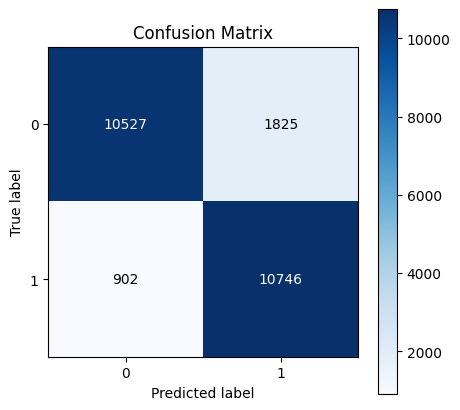

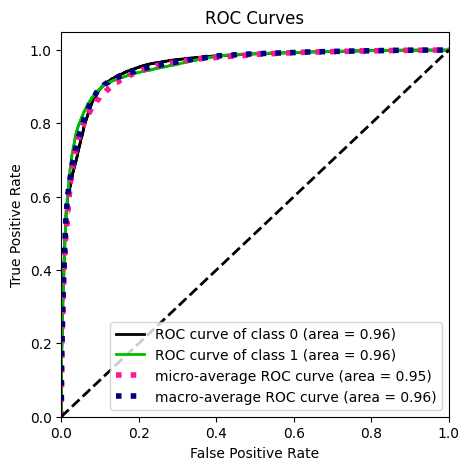

INFO:root:Validation Set Evaluation
INFO:root:Variable(s) of interest ['BOUGHTPASS'] AUC: 0.902    Accuracy: 0.828    Balanced Accuracy: 0.829
INFO:root:Feature Importance df: 
                           COLS     IMP
0                     EVERPASS  0.2748
1            SUBSEASONSPERYEAR  0.0314
2         MOSTCOMMONTICKETCOMP  0.0310
3                GUESTBEHAVIOR  0.0144
4                  TOTALVISITS  0.0106
5                 EVERCOREPASS  0.0102
6                          AGE  0.0070
7           ISEPICMIXACTIVATED  0.0066
8   DESTINATIONGEOAFINITYLABEL  0.0056
9            MOSTVISITEDREGION  0.0044
10           AVGVISITPERSEASON  0.0040
11                  GENDERCODE  0.0036
12        MOSTSUBSEASONVISITED  0.0026
13         TOTALSEASONSSCANNED  0.0024
14         ONLYSINGLERESORTKEY  0.0008
15             VISITMOSTINPEAK  0.0006
16    PARTNERRESORTSCANNERFLAG  0.0000
17              RESORTSVISITED  0.0000
18           SKIERABILITYLABEL -0.0002
19               MARKETINGZONE -0.0004
20 

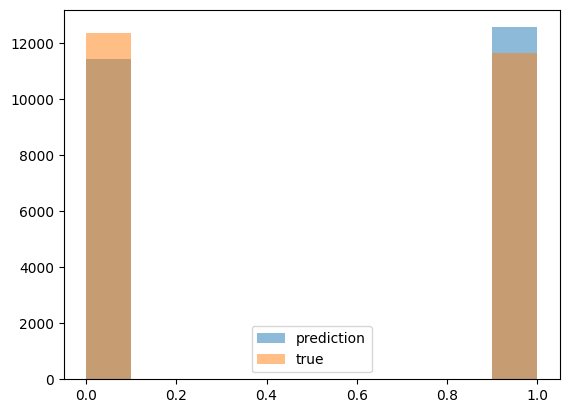

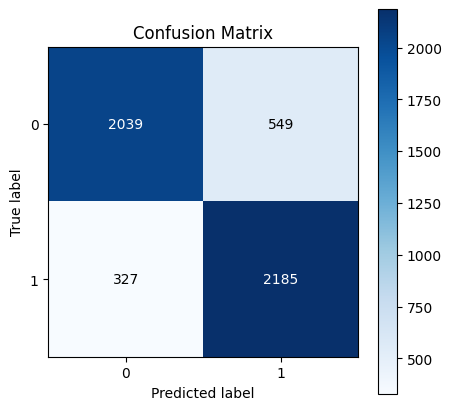

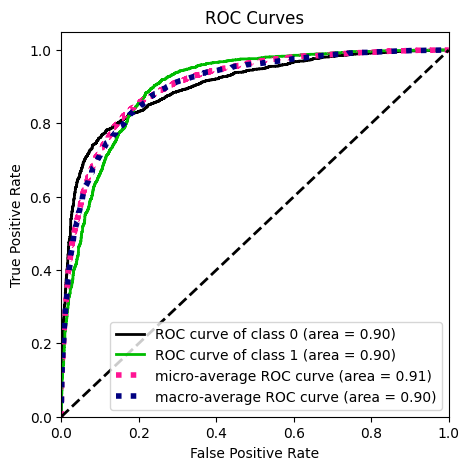

INFO:root:Test Set Evaluation
INFO:root:Variable(s) of interest ['BOUGHTPASS'] AUC: 0.894    Accuracy: 0.824    Balanced Accuracy: 0.826
INFO:root:Feature Importance df: 
                           COLS       IMP
0                     EVERPASS  0.274444
1         MOSTCOMMONTICKETCOMP  0.033333
2            SUBSEASONSPERYEAR  0.020000
3                GUESTBEHAVIOR  0.008889
4                 EVERCOREPASS  0.008889
5           ISEPICMIXACTIVATED  0.007778
6            SKIERABILITYLABEL  0.004444
7                          AGE  0.004444
8          TOTALSEASONSSCANNED  0.004444
9            MOSTVISITEDREGION  0.002222
10                  GENDERCODE  0.002222
11           AVGVISITPERSEASON  0.002222
12         ONLYSINGLERESORTKEY  0.002222
13           MOSTVISITEDRESORT  0.001111
14        MOSTSUBSEASONVISITED  0.001111
15              RESORTSVISITED  0.001111
16    PARTNERRESORTSCANNERFLAG  0.000000
17             VISITMOSTINPEAK  0.000000
18               MARKETINGZONE -0.001111
19      

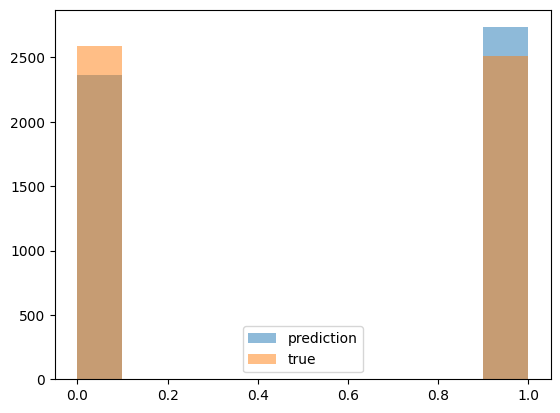

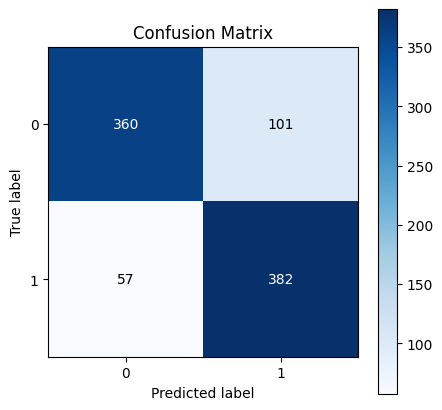

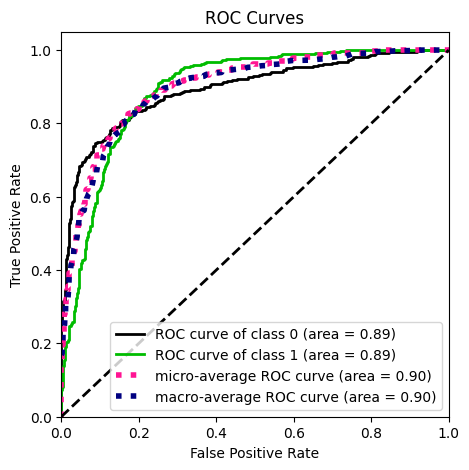

INFO:root:hold out data preview going to snowflake            ECID SEASONYEAR  PROBABILITY          DATECREATED  \
14448  74003818    2019/20     0.819886  2022-11-01 19:49:21   
12515  96795212    2019/20     0.193836  2022-11-01 19:49:21   
2167   57188596    2019/20     0.876624  2022-11-01 19:49:21   

           EXP_COMMIT_CI_SHA  
14448  BASELINE_LocalRunTest  
12515  BASELINE_LocalRunTest  
2167   BASELINE_LocalRunTest  
INFO:data_system_utilities.snowflake.query:creating table LTBP_HOLDOUT_TEST_MODEL_RESULTS
INFO:data_system_utilities.snowflake.query:sqlalchemy snowflake engine created
INFO:data_system_utilities.snowflake.query:table created
INFO:root:saving test prediction file
INFO:root:sending prediction file to azure to projects/LTBP/FY23/experiments/BASELINE/holdout_results/
INFO:data_system_utilities.azure.storage:Uploading holdout_BASELINELocalRunTest.csv, to Azure Storage projects/LTBP/FY23/experiments/BASELINE/holdout_results/holdout_BASELINELocalRunTest.csv
INFO:data_

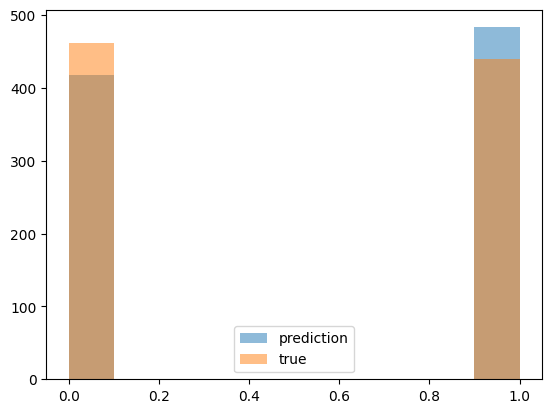

In [ ]:
#| skip

yaml_file_list=['features.yaml', 'udf_inputs.yaml','etl.yaml','models.yaml']
prod_or_dev = 'dev'
experiment_name='BASELINE'
experiment = True # this will trigger if the feature set needs to be created
test_set = True

# Grab all yaml files for current probject
features, udf_inputs, etl_dict, models_dict = get_yaml_dicts(yaml_file_list)

# Create Snowflake Stage and Query Experiment location or commit location and return training data
sf = snowflake_query(sfSchema=prod_or_dev if prod_or_dev.lower() == 'dev' else 'LTBP')
df = create_stage_and_query_stage_sf(
    sf=sf,
    etl=etl_dict,
    udf_inputs=udf_inputs,
    train_or_inference='TRAINING',
    experiment_name=experiment_name,
    experiment=experiment,
    indentification=models_dict['identification']
    )

# Choosing an adls path depending on experiment being true or false
adls_path = os.path.join(
    (os.path.join(etl_dict['data_lake_path'], 'experiments', experiment_name)
     if experiment
     else os.path.join(
         etl_dict['data_lake_path'],
         os.environ.get('CI_COMMIT_SHA', 'LocalRunNBS'))
    )
    , models_dict['preprocessors_adls_path']
    , models_dict['BASELINE']['model_trainer'])

# Grab all Categorical and Continous Variables for Modeling
cat_vars = [{f.upper(): values['transformation'][experiment_name]} for f, values in features.items()
            if values['var_type'][experiment_name] == 'cat'
            and values['input_definition'] != 'LABEL']
cont_vars = [{f.upper(): values['transformation'][experiment_name]} for f, values in features.items()
             if values['var_type'][experiment_name] == 'cont'
             and values['input_definition'] != 'LABEL']
y_var = [k.upper() for k, v in features.items() if v['input_definition'] == 'LABEL']

# Create Dictionary and create sklearn preprocessing Pipeline
feature_dict = create_sklearn_preprocess_baseline_dict(cat_vars=cat_vars,
                                                       cont_vars=cont_vars)
logging.info(feature_dict)
cat_vars = return_list_of_vars(cat_vars)
cont_vars = return_list_of_vars(cont_vars)
logging.info(f"categorical variables: \n {cat_vars}")
logging.info(f"continous variables: \n {cont_vars}")
pipe = preprocessing.generate_sklearn_preprocessing_pipeline(
    feature_dict, impute=True, impute_strategy='mean'
)

# Preprocess and split data set to return neccessary object for modeling
result = prepare_training_set(df,
                              y_var=[k.upper() for k, v in features.items() if v['input_definition'] == 'LABEL'],
                              y_scaler_type=models_dict[experiment_name]['y_scaler_type'],
                              adls_path=adls_path,
                              sklearn_pipe=pipe,
                              test_set=test_set,
                              etl_dict=etl_dict,
                              models_dict=models_dict,
                              connection_str=os.environ[models_dict["connection_str"]],
                              experiment_name=experiment_name,
                              as_type=int,
                              identifiers=['ECID', 'SEASONYEAR']
                              )
if test_set:
    X_train, X_valid, X_test, y_train, y_valid, y_test, sklearn_pipe, scaler, id_list = result
else:
    X_train, X_valid, y_train, y_valid, sklearn_pipe, scaler, id_list = result

# Choosing model from models.py to use from models.yaml file
model_trainer = getattr(ds_models, models_dict[experiment_name]['model_trainer'])
model = model_trainer(X_train,
                      X_valid,
                      y_train,
                      y_valid,
                      evals=models_dict[experiment_name]['hyperopt_evals'],
                      sub=models_dict[experiment_name]['hyper_opt_subsample_size'],
                      train=models_dict[experiment_name]['training_subsample_size'])

"""
Custom needs for each project type this works for a binary classification
this is not my best work, but trying to put something together
this is dry I am sure i could make this just a few lines
"""
result_dict = {}
logging.info('Training Set Evaluation')

eval_list_train = evaluate(model, X_train, y_train, y_var, feature_importance=True, plot=True)
metric1, metric2, metric3, columns, _, _, fi_permutation = eval_list_train
result_dict['training_metrics'] = {k: v for k, v in zip(columns, [metric1]+[metric2]+[metric3])}
result_dict['fi_train'] = {k: v for k, v in fi_permutation[:10].values}
logging.info('Validation Set Evaluation')
eval_list_valid = evaluate(model, X_valid, y_valid, y_var, feature_importance=True, plot=True)
metric1, metric2, metric3, columns, y_pred_proba, y_pred, fi_permutation = eval_list_valid
result_dict['valid_metrics'] = {k: v for k, v in zip(columns, [metric1]+[metric2]+[metric3])}
result_dict['fi_valid'] = {k: v for k, v in fi_permutation[:10].values}
if X_test is not None:
    logging.info('Test Set Evaluation')
    eval_list_test = evaluate(model, X_test, y_test, y_var, feature_importance=True, plot=True)
    metric1, metric2, metric3, columns, y_pred_proba, y_pred, fi_permutation = eval_list_test
    result_dict['test_metrics'] = {k: v for k, v in zip(columns, [metric1]+[metric2]+[metric3])}
    result_dict['fi_test'] = {k: v for k, v in fi_permutation[:10].values}

sf = snowflake_query(sfSchema='LTBP')
send_holdout_results_to_sf(sf=sf,
                           id_list=id_list,
                           probs=y_pred_proba,
                           experiment=experiment,
                           experiment_name=experiment_name,
                           etl_dict=etl_dict,
                           model_dict=models_dict)

adls_path = os.path.join(
    (os.path.join(etl_dict['data_lake_path'], 'experiments', experiment_name)
     if experiment else os.path.join(
         etl_dict['data_lake_path'], os.environ.get('CI_COMMIT_SHA', 'LocalRunNBS'))
    )
)

project_log_df = project_log.project_log(
    snowflake_connection=sf,
    table_name=models_dict['tracking_table'],
    action_description=models_dict[experiment_name]["description"],
    transaction_type="model_training",
    artifacts=json.dumps({"azure_parent_folder": adls_path}),
    metrics=json.dumps(result_dict),
    append_or_replace="append",
)
logging.info(f'project log preview:\n{project_log_df.head(2)}')

# Saving sklearn pipeline to adls
logging.info('Saving model and sending it to adls')
full_pipeline = Pipeline([('preprocessing', pipe), ('classification', model)])
adls_path = os.path.join(adls_path
                         , models_dict['modeling_adls_path']
                         , models_dict['BASELINE']['model_trainer'])
save_sklearn_object_to_data_lake(
    save_object=full_pipeline,
    adls_path=adls_path,
    file_name=(models_dict[experiment_name]['model_trainer']+
               os.environ.get('CI_COMMIT_SHA', 'LocalRunNBS')+
               experiment_name+'.pkl'
              ),
    container_name=etl_dict['azure_container'],
    connection_str=os.environ[models_dict['connection_str']]
)

These just help clean up the tables that would be created by this notebook make sure you only use the below code when in development otherwise you production or your dev results that you have could be deleted.

In [ ]:
#| skip
# sf.run_sql_str(f"DROP TABLE {models_dict['tracking_table']}")
# sf.run_sql_str(f"DROP TABLE MACHINELEARNINGOUTPUTS.dev.{models_dict['hold_out_table']}")

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()